In [2]:
!pip install keras

# train_model.py
import os
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [3]:
!pip install opencv-python mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 11.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.7 which is incompatible.
ydf 0.11.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 4.25.7 which is inco

In [4]:
import mediapipe as mp

In [5]:
from google.colab import files

# Upload the zip file (run this cell and manually upload your dataset)
uploaded = files.upload()

# Extract the zip file
zip_path = next(iter(uploaded))
extract_folder = '/content/yoga_dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# Verify the folder structure
!ls /content/dataset1

Saving dataset1.zip to dataset1.zip
ls: cannot access '/content/dataset1': No such file or directory


In [6]:
# Initializing mediapipe pose class.
mp_pose = mp.solutions.pose

# Setting up the Pose function.
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.3, model_complexity=2)

# Initializing mediapipe drawing class, useful for annotation.
mp_drawing = mp.solutions.drawing_utils

In [7]:
import os
import cv2
import pandas as pd
import mediapipe as mp
from tqdm import tqdm  # For progress bars

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(
    static_image_mode=True,
    min_detection_confidence=0.3,  # Lowered threshold
    model_complexity=2  # Higher accuracy
)

def extract_keypoints(image_path):
    """Improved version with better error handling"""
    try:
        image = cv2.imread(image_path)
        if image is None:
            print(f"Could not read image: {image_path}")
            return None

        # Convert BGR to RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Process the image
        results = pose.process(image_rgb)

        if not results.pose_landmarks:
            print(f"No pose detected in: {image_path}")
            return None

        # Extract just x,y coordinates (more reliable than x,y,z,visibility)
        landmarks = []
        for landmark in results.pose_landmarks.landmark:
            landmarks.extend([landmark.x, landmark.y])  # Only x,y

        return landmarks  # 66 values (33 landmarks × 2 coordinates)

    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        return None

def process_dataset(dataset_path):
    """Fixed version with recursive folder search"""
    data = []
    labels = []
    processed_count = 0
    failed_count = 0

    print(f"\nScanning dataset at: {dataset_path}")

    # Walk through all subdirectories
    for root, dirs, files in os.walk(dataset_path):
        for file in tqdm(files, desc=f"Processing {os.path.basename(root)}"):
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(root, file)

                # Get pose name from parent folder (assuming structure: /root/pose_name/...)
                pose_name = os.path.basename(root)

                keypoints = extract_keypoints(image_path)
                if keypoints:
                    data.append(keypoints)
                    labels.append(pose_name)
                    processed_count += 1
                else:
                    failed_count += 1

    print(f"\nResults:")
    print(f"- Successfully processed: {processed_count} images")
    print(f"- Failed to process: {failed_count} images")

    if not data:
        raise ValueError("No valid poses found! Check:")
        print("1. Image paths are correct")
        print("2. Images contain clear full-body poses")
        print("3. Folder structure matches expected format")

    # Create DataFrame with column names
    columns = [f"joint_{i//2}_x" if i%2==0 else f"joint_{i//2}_y"
               for i in range(66)]  # For 33 joints (x,y)

    df = pd.DataFrame(data, columns=columns)
    df['pose_name'] = labels

    return df

# Test with a sample image first
# print("Testing with sample image...")
# test_image_path = "/content/dataset/Warrior-Pose/image1.jpg"  # Change to a real path
# test_keypoints = extract_keypoints(test_image_path)
# print(f"Test keypoints: {'Found' if test_keypoints else 'Missing'}")

# Process full dataset
dataset_path = '/content/yoga_dataset'
try:
    df = process_dataset(dataset_path)
    print("\nSample data:")
    print(df.head())

    # Save to CSV
    csv_path = '/content/yoga_pose_keypoints.csv'
    df.to_csv(csv_path, index=False)
    print(f"\nSaved to: {csv_path}")

except Exception as e:
    print(f"\nCritical error: {str(e)}")
    print("Check these common issues:")
    print("1. Wrong dataset_path (current: {dataset_path})")
    print("2. Images don't contain detectable full-body poses")
    print("3. MediaPipe not detecting poses (try simpler images)")


Scanning dataset at: /content/yoga_dataset


Processing yoga_dataset: 0it [00:00, ?it/s]
Processing Standing-Mountain-Pose-20221027T035550Z-001: 0it [00:00, ?it/s]
Processing Standing-Mountain-Pose:   6%|▌         | 11/198 [00:01<00:21,  8.79it/s]

No pose detected in: /content/yoga_dataset/Standing-Mountain-Pose-20221027T035550Z-001/Standing-Mountain-Pose/images33.jpg


Processing Standing-Mountain-Pose:   9%|▊         | 17/198 [00:02<00:19,  9.50it/s]

No pose detected in: /content/yoga_dataset/Standing-Mountain-Pose-20221027T035550Z-001/Standing-Mountain-Pose/Variations-of-Mountain-Pose-FITZABOUT-1024x1024.jpg


Processing Standing-Mountain-Pose:  27%|██▋       | 54/198 [00:09<00:20,  7.16it/s]

No pose detected in: /content/yoga_dataset/Standing-Mountain-Pose-20221027T035550Z-001/Standing-Mountain-Pose/mountain-pose-benefits-2.png


Processing Standing-Mountain-Pose:  29%|██▉       | 58/198 [00:09<00:18,  7.58it/s]

No pose detected in: /content/yoga_dataset/Standing-Mountain-Pose-20221027T035550Z-001/Standing-Mountain-Pose/image6.jpeg


Processing Standing-Mountain-Pose:  51%|█████     | 101/198 [00:15<00:10,  9.01it/s]

No pose detected in: /content/yoga_dataset/Standing-Mountain-Pose-20221027T035550Z-001/Standing-Mountain-Pose/blog-mountain_600x.jpg


Processing Standing-Mountain-Pose:  53%|█████▎    | 105/198 [00:16<00:12,  7.60it/s]

No pose detected in: /content/yoga_dataset/Standing-Mountain-Pose-20221027T035550Z-001/Standing-Mountain-Pose/image12.jpeg


Processing Standing-Mountain-Pose:  62%|██████▏   | 123/198 [00:19<00:12,  6.21it/s]

No pose detected in: /content/yoga_dataset/Standing-Mountain-Pose-20221027T035550Z-001/Standing-Mountain-Pose/792b80fd0c884040bbcfaf14656788f7.png


Processing Standing-Mountain-Pose:  68%|██████▊   | 134/198 [00:21<00:07,  8.88it/s]

No pose detected in: /content/yoga_dataset/Standing-Mountain-Pose-20221027T035550Z-001/Standing-Mountain-Pose/image2.jpeg


Processing Standing-Mountain-Pose:  69%|██████▉   | 137/198 [00:21<00:06, 10.00it/s]

No pose detected in: /content/yoga_dataset/Standing-Mountain-Pose-20221027T035550Z-001/Standing-Mountain-Pose/AOh-ky1xuGSuo1cFBPOmcqkrelO7CtXbSsHfwZPiu8CQbAs64-c-mo.jpg
No pose detected in: /content/yoga_dataset/Standing-Mountain-Pose-20221027T035550Z-001/Standing-Mountain-Pose/image11.jpeg


Processing Standing-Mountain-Pose:  73%|███████▎  | 145/198 [00:22<00:06,  8.42it/s]

No pose detected in: /content/yoga_dataset/Standing-Mountain-Pose-20221027T035550Z-001/Standing-Mountain-Pose/extended_mountain_pose_with_backbend__utthita_tadasana_with_backbend_yoga.png
No pose detected in: /content/yoga_dataset/Standing-Mountain-Pose-20221027T035550Z-001/Standing-Mountain-Pose/mountain-pose-tadasana2.jpg


Processing Standing-Mountain-Pose:  76%|███████▌  | 150/198 [00:23<00:05,  8.60it/s]

No pose detected in: /content/yoga_dataset/Standing-Mountain-Pose-20221027T035550Z-001/Standing-Mountain-Pose/image7.jpeg


Processing Standing-Mountain-Pose:  87%|████████▋ | 173/198 [00:26<00:02,  9.02it/s]

No pose detected in: /content/yoga_dataset/Standing-Mountain-Pose-20221027T035550Z-001/Standing-Mountain-Pose/Tadasana4.png


Processing Standing-Mountain-Pose:  90%|████████▉ | 178/198 [00:26<00:01, 10.89it/s]

No pose detected in: /content/yoga_dataset/Standing-Mountain-Pose-20221027T035550Z-001/Standing-Mountain-Pose/images32.jpg
No pose detected in: /content/yoga_dataset/Standing-Mountain-Pose-20221027T035550Z-001/Standing-Mountain-Pose/yogaPoseKids-mountain.png


Processing Standing-Mountain-Pose:  98%|█████████▊| 195/198 [00:28<00:00,  9.25it/s]

No pose detected in: /content/yoga_dataset/Standing-Mountain-Pose-20221027T035550Z-001/Standing-Mountain-Pose/images64.jpg


Processing Standing-Mountain-Pose: 100%|██████████| 198/198 [00:29<00:00,  6.81it/s]
Processing Pigeon-Pose-20221027T035540Z-001: 0it [00:00, ?it/s]
Processing Pigeon-Pose:   6%|▌         | 13/210 [00:02<00:38,  5.15it/s]

No pose detected in: /content/yoga_dataset/Pigeon-Pose-20221027T035540Z-001/Pigeon-Pose/images33.jpg


Processing Pigeon-Pose:  15%|█▌        | 32/210 [00:05<00:24,  7.12it/s]

No pose detected in: /content/yoga_dataset/Pigeon-Pose-20221027T035540Z-001/Pigeon-Pose/images69.jpg


Processing Pigeon-Pose:  20%|█▉        | 41/210 [00:06<00:21,  7.69it/s]

No pose detected in: /content/yoga_dataset/Pigeon-Pose-20221027T035540Z-001/Pigeon-Pose/images71.jpg


Processing Pigeon-Pose:  29%|██▉       | 61/210 [00:08<00:16,  9.29it/s]

No pose detected in: /content/yoga_dataset/Pigeon-Pose-20221027T035540Z-001/Pigeon-Pose/images2.jpg


Processing Pigeon-Pose:  46%|████▌     | 96/210 [00:13<00:15,  7.41it/s]

No pose detected in: /content/yoga_dataset/Pigeon-Pose-20221027T035540Z-001/Pigeon-Pose/image12.jpeg


Processing Pigeon-Pose:  60%|██████    | 127/210 [00:18<00:08,  9.35it/s]

No pose detected in: /content/yoga_dataset/Pigeon-Pose-20221027T035540Z-001/Pigeon-Pose/image13.jpeg


Processing Pigeon-Pose:  64%|██████▍   | 134/210 [00:19<00:07,  9.79it/s]

No pose detected in: /content/yoga_dataset/Pigeon-Pose-20221027T035540Z-001/Pigeon-Pose/AOh-ky1xuGSuo1cFBPOmcqkrelO7CtXbSsHfwZPiu8CQbAs64-c-mo.jpg


Processing Pigeon-Pose:  68%|██████▊   | 142/210 [00:20<00:06,  9.90it/s]

No pose detected in: /content/yoga_dataset/Pigeon-Pose-20221027T035540Z-001/Pigeon-Pose/image7.jpeg


Processing Pigeon-Pose:  75%|███████▌  | 158/210 [00:23<00:14,  3.71it/s]

No pose detected in: /content/yoga_dataset/Pigeon-Pose-20221027T035540Z-001/Pigeon-Pose/de5a5ac6ab959b5ae9a1dbb9bfc4fe48.jpg


Processing Pigeon-Pose:  81%|████████▏ | 171/210 [00:25<00:04,  8.52it/s]

No pose detected in: /content/yoga_dataset/Pigeon-Pose-20221027T035540Z-001/Pigeon-Pose/images82.jpg


Processing Pigeon-Pose:  84%|████████▍ | 176/210 [00:25<00:03,  9.13it/s]

No pose detected in: /content/yoga_dataset/Pigeon-Pose-20221027T035540Z-001/Pigeon-Pose/images39.jpg
No pose detected in: /content/yoga_dataset/Pigeon-Pose-20221027T035540Z-001/Pigeon-Pose/image21.jpeg


Processing Pigeon-Pose:  87%|████████▋ | 183/210 [00:27<00:04,  5.87it/s]

No pose detected in: /content/yoga_dataset/Pigeon-Pose-20221027T035540Z-001/Pigeon-Pose/images8.jpg


Processing Pigeon-Pose: 100%|██████████| 210/210 [00:32<00:00,  6.56it/s]


No pose detected in: /content/yoga_dataset/Pigeon-Pose-20221027T035540Z-001/Pigeon-Pose/images27.jpg


Processing Downward-Dog-Pose-20221027T035536Z-001: 0it [00:00, ?it/s]
Processing Downward-Dog-Pose:   1%|          | 2/226 [00:00<00:15, 14.44it/s]

No pose detected in: /content/yoga_dataset/Downward-Dog-Pose-20221027T035536Z-001/Downward-Dog-Pose/images63.jpg


Processing Downward-Dog-Pose:   9%|▉         | 20/226 [00:02<00:20,  9.93it/s]

No pose detected in: /content/yoga_dataset/Downward-Dog-Pose-20221027T035536Z-001/Downward-Dog-Pose/59379e4bcb4f419aad86e5c76ba38a7d.png
No pose detected in: /content/yoga_dataset/Downward-Dog-Pose-20221027T035536Z-001/Downward-Dog-Pose/images12.jpg


Processing Downward-Dog-Pose:  20%|█▉        | 45/226 [00:05<00:20,  8.92it/s]

No pose detected in: /content/yoga_dataset/Downward-Dog-Pose-20221027T035536Z-001/Downward-Dog-Pose/images20.jpg


Processing Downward-Dog-Pose:  22%|██▏       | 49/226 [00:05<00:18,  9.63it/s]

No pose detected in: /content/yoga_dataset/Downward-Dog-Pose-20221027T035536Z-001/Downward-Dog-Pose/yoga-pose-set-downward-dog-2267678152.jpg


Processing Downward-Dog-Pose:  23%|██▎       | 53/226 [00:06<00:16, 10.23it/s]

No pose detected in: /content/yoga_dataset/Downward-Dog-Pose-20221027T035536Z-001/Downward-Dog-Pose/image9.jpeg
No pose detected in: /content/yoga_dataset/Downward-Dog-Pose-20221027T035536Z-001/Downward-Dog-Pose/downward-facing-dog-pose-adho-mukha-svanasana.jpg


Processing Downward-Dog-Pose:  28%|██▊       | 63/226 [00:07<00:15, 10.27it/s]

No pose detected in: /content/yoga_dataset/Downward-Dog-Pose-20221027T035536Z-001/Downward-Dog-Pose/images44.jpg


Processing Downward-Dog-Pose:  31%|███       | 69/226 [00:07<00:12, 12.56it/s]

No pose detected in: /content/yoga_dataset/Downward-Dog-Pose-20221027T035536Z-001/Downward-Dog-Pose/images9.jpg
No pose detected in: /content/yoga_dataset/Downward-Dog-Pose-20221027T035536Z-001/Downward-Dog-Pose/images66.jpg
No pose detected in: /content/yoga_dataset/Downward-Dog-Pose-20221027T035536Z-001/Downward-Dog-Pose/yoga-harmony-sketch-vector-illustration-isolated-on-white-background-2E3XG8F.jpg


Processing Downward-Dog-Pose:  40%|███▉      | 90/226 [00:11<00:16,  8.01it/s]

No pose detected in: /content/yoga_dataset/Downward-Dog-Pose-20221027T035536Z-001/Downward-Dog-Pose/yoga-pose-set-downward-dog-226767815.jpg


Processing Downward-Dog-Pose:  49%|████▊     | 110/226 [00:13<00:11, 10.31it/s]

No pose detected in: /content/yoga_dataset/Downward-Dog-Pose-20221027T035536Z-001/Downward-Dog-Pose/images92.jpg


Processing Downward-Dog-Pose:  60%|█████▉    | 135/226 [00:17<00:09,  9.32it/s]

No pose detected in: /content/yoga_dataset/Downward-Dog-Pose-20221027T035536Z-001/Downward-Dog-Pose/image15.jpeg


Processing Downward-Dog-Pose:  62%|██████▏   | 139/226 [00:17<00:08,  9.86it/s]

No pose detected in: /content/yoga_dataset/Downward-Dog-Pose-20221027T035536Z-001/Downward-Dog-Pose/images83.jpg


Processing Downward-Dog-Pose:  65%|██████▍   | 146/226 [00:18<00:07, 10.49it/s]

No pose detected in: /content/yoga_dataset/Downward-Dog-Pose-20221027T035536Z-001/Downward-Dog-Pose/images102.jpg


Processing Downward-Dog-Pose:  68%|██████▊   | 154/226 [00:19<00:08,  8.25it/s]

No pose detected in: /content/yoga_dataset/Downward-Dog-Pose-20221027T035536Z-001/Downward-Dog-Pose/images67.jpg


Processing Downward-Dog-Pose:  70%|██████▉   | 158/226 [00:19<00:07,  9.36it/s]

No pose detected in: /content/yoga_dataset/Downward-Dog-Pose-20221027T035536Z-001/Downward-Dog-Pose/AOh-ky1xuGSuo1cFBPOmcqkrelO7CtXbSsHfwZPiu8CQbAs64-c-mo.jpg


Processing Downward-Dog-Pose: 100%|██████████| 226/226 [00:30<00:00,  7.51it/s]
Processing Tree-Pose-20221027T035555Z-001: 0it [00:00, ?it/s]
Processing Tree-Pose:   2%|▏         | 6/334 [00:00<00:32, 10.09it/s]

No pose detected in: /content/yoga_dataset/Tree-Pose-20221027T035555Z-001/Tree-Pose/images147.jpg


Processing Tree-Pose:   4%|▍         | 14/334 [00:01<00:38,  8.29it/s]

No pose detected in: /content/yoga_dataset/Tree-Pose-20221027T035555Z-001/Tree-Pose/images116.jpg


Processing Tree-Pose:   8%|▊         | 27/334 [00:03<00:32,  9.50it/s]

No pose detected in: /content/yoga_dataset/Tree-Pose-20221027T035555Z-001/Tree-Pose/images19.jpg


Processing Tree-Pose:  13%|█▎        | 44/334 [00:05<00:44,  6.56it/s]

No pose detected in: /content/yoga_dataset/Tree-Pose-20221027T035555Z-001/Tree-Pose/images72.jpg


Processing Tree-Pose:  14%|█▍        | 48/334 [00:06<00:53,  5.32it/s]

No pose detected in: /content/yoga_dataset/Tree-Pose-20221027T035555Z-001/Tree-Pose/images69.jpg


Processing Tree-Pose:  15%|█▌        | 51/334 [00:07<00:48,  5.79it/s]

No pose detected in: /content/yoga_dataset/Tree-Pose-20221027T035555Z-001/Tree-Pose/images111.jpg


Processing Tree-Pose:  18%|█▊        | 61/334 [00:08<00:28,  9.73it/s]

No pose detected in: /content/yoga_dataset/Tree-Pose-20221027T035555Z-001/Tree-Pose/images70.jpg


Processing Tree-Pose:  23%|██▎       | 77/334 [00:10<00:26,  9.69it/s]

No pose detected in: /content/yoga_dataset/Tree-Pose-20221027T035555Z-001/Tree-Pose/double_tree_pose__dvi_vrksasana_yoga.png


Processing Tree-Pose:  26%|██▋       | 88/334 [00:11<00:30,  8.11it/s]

No pose detected in: /content/yoga_dataset/Tree-Pose-20221027T035555Z-001/Tree-Pose/images44.jpg


Processing Tree-Pose:  28%|██▊       | 95/334 [00:12<00:25,  9.36it/s]

No pose detected in: /content/yoga_dataset/Tree-Pose-20221027T035555Z-001/Tree-Pose/yoga-tree-pose-variations-male-set-vector-25148654.jpg
No pose detected in: /content/yoga_dataset/Tree-Pose-20221027T035555Z-001/Tree-Pose/images170.jpg


Processing Tree-Pose:  31%|███       | 103/334 [00:13<00:27,  8.55it/s]

No pose detected in: /content/yoga_dataset/Tree-Pose-20221027T035555Z-001/Tree-Pose/images78.jpg


Processing Tree-Pose:  33%|███▎      | 109/334 [00:14<00:28,  7.90it/s]

No pose detected in: /content/yoga_dataset/Tree-Pose-20221027T035555Z-001/Tree-Pose/images40.jpg


Processing Tree-Pose:  34%|███▍      | 113/334 [00:14<00:25,  8.52it/s]

No pose detected in: /content/yoga_dataset/Tree-Pose-20221027T035555Z-001/Tree-Pose/tree-pose-yoga-workout-outline-260nw-1911225373.jpg


Processing Tree-Pose:  35%|███▌      | 117/334 [00:15<00:27,  8.02it/s]

No pose detected in: /content/yoga_dataset/Tree-Pose-20221027T035555Z-001/Tree-Pose/images4.jpg
No pose detected in: /content/yoga_dataset/Tree-Pose-20221027T035555Z-001/Tree-Pose/images100.jpg


Processing Tree-Pose:  39%|███▉      | 131/334 [00:17<00:25,  7.97it/s]

No pose detected in: /content/yoga_dataset/Tree-Pose-20221027T035555Z-001/Tree-Pose/images17.jpg


Processing Tree-Pose:  42%|████▏     | 140/334 [00:19<00:38,  5.02it/s]

No pose detected in: /content/yoga_dataset/Tree-Pose-20221027T035555Z-001/Tree-Pose/images92.jpg


Processing Tree-Pose:  44%|████▍     | 148/334 [00:20<00:25,  7.39it/s]

No pose detected in: /content/yoga_dataset/Tree-Pose-20221027T035555Z-001/Tree-Pose/images57.jpg


Processing Tree-Pose:  45%|████▍     | 150/334 [00:20<00:24,  7.57it/s]

No pose detected in: /content/yoga_dataset/Tree-Pose-20221027T035555Z-001/Tree-Pose/images86.jpg


Processing Tree-Pose:  46%|████▌     | 154/334 [00:21<00:18,  9.82it/s]

No pose detected in: /content/yoga_dataset/Tree-Pose-20221027T035555Z-001/Tree-Pose/image25.jpeg


Processing Tree-Pose:  47%|████▋     | 156/334 [00:21<00:20,  8.58it/s]

No pose detected in: /content/yoga_dataset/Tree-Pose-20221027T035555Z-001/Tree-Pose/images104.jpg


Processing Tree-Pose:  49%|████▉     | 164/334 [00:22<00:18,  9.02it/s]

No pose detected in: /content/yoga_dataset/Tree-Pose-20221027T035555Z-001/Tree-Pose/tree-pose-variations-yoga-asanas-set-vector-27104536.jpg


Processing Tree-Pose:  54%|█████▍    | 180/334 [00:24<00:17,  8.84it/s]

No pose detected in: /content/yoga_dataset/Tree-Pose-20221027T035555Z-001/Tree-Pose/images179.jpg
No pose detected in: /content/yoga_dataset/Tree-Pose-20221027T035555Z-001/Tree-Pose/images197.jpg


Processing Tree-Pose:  59%|█████▉    | 198/334 [00:26<00:15,  8.96it/s]

No pose detected in: /content/yoga_dataset/Tree-Pose-20221027T035555Z-001/Tree-Pose/yoga-tree-pose-27663077.jpg


Processing Tree-Pose:  62%|██████▏   | 206/334 [00:27<00:13,  9.50it/s]

No pose detected in: /content/yoga_dataset/Tree-Pose-20221027T035555Z-001/Tree-Pose/images99.jpg


Processing Tree-Pose:  65%|██████▍   | 217/334 [00:28<00:09, 11.84it/s]

No pose detected in: /content/yoga_dataset/Tree-Pose-20221027T035555Z-001/Tree-Pose/images97.jpg
No pose detected in: /content/yoga_dataset/Tree-Pose-20221027T035555Z-001/Tree-Pose/AOh-ky1xuGSuo1cFBPOmcqkrelO7CtXbSsHfwZPiu8CQbAs64-c-mo.jpg
No pose detected in: /content/yoga_dataset/Tree-Pose-20221027T035555Z-001/Tree-Pose/image11.jpeg


Processing Tree-Pose:  66%|██████▋   | 222/334 [00:29<00:10, 10.34it/s]

No pose detected in: /content/yoga_dataset/Tree-Pose-20221027T035555Z-001/Tree-Pose/images174.jpg


Processing Tree-Pose:  68%|██████▊   | 227/334 [00:29<00:09, 11.28it/s]

No pose detected in: /content/yoga_dataset/Tree-Pose-20221027T035555Z-001/Tree-Pose/images122.jpg
No pose detected in: /content/yoga_dataset/Tree-Pose-20221027T035555Z-001/Tree-Pose/image7.jpeg


Processing Tree-Pose:  69%|██████▊   | 229/334 [00:30<00:10, 10.00it/s]

No pose detected in: /content/yoga_dataset/Tree-Pose-20221027T035555Z-001/Tree-Pose/images134.jpg


Processing Tree-Pose:  73%|███████▎  | 245/334 [00:33<00:13,  6.62it/s]

No pose detected in: /content/yoga_dataset/Tree-Pose-20221027T035555Z-001/Tree-Pose/images42.jpg


Processing Tree-Pose:  76%|███████▋  | 255/334 [00:34<00:07, 10.23it/s]

No pose detected in: /content/yoga_dataset/Tree-Pose-20221027T035555Z-001/Tree-Pose/8182ced0e2784fc1b5737f8bda1de28a.png


Processing Tree-Pose:  78%|███████▊  | 261/334 [00:34<00:06, 12.01it/s]

No pose detected in: /content/yoga_dataset/Tree-Pose-20221027T035555Z-001/Tree-Pose/images21.jpg
No pose detected in: /content/yoga_dataset/Tree-Pose-20221027T035555Z-001/Tree-Pose/images88.jpg


Processing Tree-Pose:  81%|████████  | 269/334 [00:35<00:06, 10.44it/s]

No pose detected in: /content/yoga_dataset/Tree-Pose-20221027T035555Z-001/Tree-Pose/images.jpg


Processing Tree-Pose:  86%|████████▌ | 288/334 [00:38<00:05,  9.08it/s]

No pose detected in: /content/yoga_dataset/Tree-Pose-20221027T035555Z-001/Tree-Pose/blog-treePose_600x.jpg


Processing Tree-Pose:  89%|████████▉ | 297/334 [00:39<00:03, 10.02it/s]

No pose detected in: /content/yoga_dataset/Tree-Pose-20221027T035555Z-001/Tree-Pose/images213.jpg


Processing Tree-Pose:  91%|█████████ | 304/334 [00:39<00:02, 10.20it/s]

No pose detected in: /content/yoga_dataset/Tree-Pose-20221027T035555Z-001/Tree-Pose/images23.jpg


Processing Tree-Pose:  97%|█████████▋| 324/334 [00:42<00:01,  8.92it/s]

No pose detected in: /content/yoga_dataset/Tree-Pose-20221027T035555Z-001/Tree-Pose/Tree-pose-benefits.png


Processing Tree-Pose: 100%|██████████| 334/334 [00:44<00:00,  7.57it/s]
Processing Bridge-Pose-20221027T035527Z-001: 0it [00:00, ?it/s]
Processing Bridge-Pose:   6%|▋         | 17/268 [00:02<00:25,  9.68it/s]

No pose detected in: /content/yoga_dataset/Bridge-Pose-20221027T035527Z-001/Bridge-Pose/bridge-pose-yoga-workout-setu-bandha-vector-clipart_csp92698204.jpg
No pose detected in: /content/yoga_dataset/Bridge-Pose-20221027T035527Z-001/Bridge-Pose/images85.jpg


Processing Bridge-Pose:   8%|▊         | 21/268 [00:03<00:24,  9.99it/s]

No pose detected in: /content/yoga_dataset/Bridge-Pose-20221027T035527Z-001/Bridge-Pose/eka_pada_setubandha_sarvangasana_yoga.png


Processing Bridge-Pose:  11%|█         | 30/268 [00:04<00:24,  9.75it/s]

No pose detected in: /content/yoga_dataset/Bridge-Pose-20221027T035527Z-001/Bridge-Pose/images22.jpg


Processing Bridge-Pose:  15%|█▌        | 41/268 [00:05<00:28,  7.84it/s]

No pose detected in: /content/yoga_dataset/Bridge-Pose-20221027T035527Z-001/Bridge-Pose/images69.jpg
No pose detected in: /content/yoga_dataset/Bridge-Pose-20221027T035527Z-001/Bridge-Pose/images111.jpg


Processing Bridge-Pose:  28%|██▊       | 75/268 [00:09<00:21,  8.99it/s]

No pose detected in: /content/yoga_dataset/Bridge-Pose-20221027T035527Z-001/Bridge-Pose/images138.jpg


Processing Bridge-Pose:  33%|███▎      | 88/268 [00:11<00:19,  9.16it/s]

No pose detected in: /content/yoga_dataset/Bridge-Pose-20221027T035527Z-001/Bridge-Pose/women-silhouette-bridge-yoga-pose-setu-bandha-vector-14132938.jpg
No pose detected in: /content/yoga_dataset/Bridge-Pose-20221027T035527Z-001/Bridge-Pose/setubandha_sarvangasana_yoga.png


Processing Bridge-Pose:  38%|███▊      | 102/268 [00:14<00:32,  5.14it/s]

No pose detected in: /content/yoga_dataset/Bridge-Pose-20221027T035527Z-001/Bridge-Pose/images103.jpg


Processing Bridge-Pose:  42%|████▏     | 112/268 [00:15<00:17,  8.87it/s]

No pose detected in: /content/yoga_dataset/Bridge-Pose-20221027T035527Z-001/Bridge-Pose/images130.jpg


Processing Bridge-Pose:  44%|████▍     | 118/268 [00:16<00:19,  7.73it/s]

No pose detected in: /content/yoga_dataset/Bridge-Pose-20221027T035527Z-001/Bridge-Pose/images11.jpg


Processing Bridge-Pose:  46%|████▌     | 122/268 [00:17<00:20,  7.20it/s]

No pose detected in: /content/yoga_dataset/Bridge-Pose-20221027T035527Z-001/Bridge-Pose/images86.jpg


Processing Bridge-Pose:  49%|████▉     | 131/268 [00:19<00:19,  6.98it/s]

No pose detected in: /content/yoga_dataset/Bridge-Pose-20221027T035527Z-001/Bridge-Pose/out-outline-healthy-lifestyle-vector-illustration-white-background-209724331.jpg


Processing Bridge-Pose:  54%|█████▍    | 145/268 [00:21<00:17,  7.22it/s]

No pose detected in: /content/yoga_dataset/Bridge-Pose-20221027T035527Z-001/Bridge-Pose/image8.jpeg


Processing Bridge-Pose:  58%|█████▊    | 155/268 [00:22<00:13,  8.37it/s]

No pose detected in: /content/yoga_dataset/Bridge-Pose-20221027T035527Z-001/Bridge-Pose/images96.jpg


Processing Bridge-Pose:  60%|█████▉    | 160/268 [00:23<00:12,  8.76it/s]

No pose detected in: /content/yoga_dataset/Bridge-Pose-20221027T035527Z-001/Bridge-Pose/images110.jpg


Processing Bridge-Pose:  64%|██████▍   | 172/268 [00:26<00:26,  3.59it/s]

No pose detected in: /content/yoga_dataset/Bridge-Pose-20221027T035527Z-001/Bridge-Pose/AOh-ky1xuGSuo1cFBPOmcqkrelO7CtXbSsHfwZPiu8CQbAs64-c-mo.jpg


Processing Bridge-Pose:  68%|██████▊   | 182/268 [00:29<00:18,  4.63it/s]

No pose detected in: /content/yoga_dataset/Bridge-Pose-20221027T035527Z-001/Bridge-Pose/bridge-pose-yoga-workout-outline-vector-clipart_csp89556108.jpg


Processing Bridge-Pose:  71%|███████▏  | 191/268 [00:30<00:09,  7.85it/s]

No pose detected in: /content/yoga_dataset/Bridge-Pose-20221027T035527Z-001/Bridge-Pose/images79.jpg


Processing Bridge-Pose:  82%|████████▏ | 221/268 [00:35<00:06,  7.31it/s]

No pose detected in: /content/yoga_dataset/Bridge-Pose-20221027T035527Z-001/Bridge-Pose/images5.jpg


Processing Bridge-Pose:  90%|████████▉ | 240/268 [00:37<00:03,  8.70it/s]

No pose detected in: /content/yoga_dataset/Bridge-Pose-20221027T035527Z-001/Bridge-Pose/ular-woman-yoga-position-bridge-pose-exercise-muscular-system-body-140987579.jpg


Processing Bridge-Pose:  95%|█████████▍| 254/268 [00:39<00:01,  8.03it/s]

No pose detected in: /content/yoga_dataset/Bridge-Pose-20221027T035527Z-001/Bridge-Pose/bridge-pose-setu-bandha-sarvangasana.jpg


Processing Bridge-Pose:  96%|█████████▌| 257/268 [00:39<00:01,  9.02it/s]

No pose detected in: /content/yoga_dataset/Bridge-Pose-20221027T035527Z-001/Bridge-Pose/images55.jpg


Processing Bridge-Pose: 100%|██████████| 268/268 [00:41<00:00,  6.40it/s]
Processing Warrior-Pose-20221027T035600Z-001: 0it [00:00, ?it/s]
Processing Warrior-Pose:  38%|███▊      | 80/209 [00:11<00:13,  9.46it/s]

No pose detected in: /content/yoga_dataset/Warrior-Pose-20221027T035600Z-001/Warrior-Pose/81d1e8fc4c184e1cb7469b7157c17f1a.png


Processing Warrior-Pose:  63%|██████▎   | 132/209 [00:19<00:07,  9.74it/s]

No pose detected in: /content/yoga_dataset/Warrior-Pose-20221027T035600Z-001/Warrior-Pose/AOh-ky1xuGSuo1cFBPOmcqkrelO7CtXbSsHfwZPiu8CQbAs64-c-mo.jpg


Processing Warrior-Pose:  65%|██████▍   | 135/209 [00:19<00:06, 10.87it/s]

No pose detected in: /content/yoga_dataset/Warrior-Pose-20221027T035600Z-001/Warrior-Pose/images48.jpg


Processing Warrior-Pose:  71%|███████▏  | 149/209 [00:21<00:06,  9.61it/s]

No pose detected in: /content/yoga_dataset/Warrior-Pose-20221027T035600Z-001/Warrior-Pose/images84.jpg


Processing Warrior-Pose:  82%|████████▏ | 171/209 [00:24<00:03, 11.17it/s]

No pose detected in: /content/yoga_dataset/Warrior-Pose-20221027T035600Z-001/Warrior-Pose/images5.jpg
No pose detected in: /content/yoga_dataset/Warrior-Pose-20221027T035600Z-001/Warrior-Pose/images68.jpg


Processing Warrior-Pose:  83%|████████▎ | 173/209 [00:24<00:02, 12.14it/s]

No pose detected in: /content/yoga_dataset/Warrior-Pose-20221027T035600Z-001/Warrior-Pose/warrior-two-pose-yoga-workout-260nw-2004773738.jpg


Processing Warrior-Pose:  89%|████████▉ | 187/209 [00:26<00:03,  6.34it/s]

No pose detected in: /content/yoga_dataset/Warrior-Pose-20221027T035600Z-001/Warrior-Pose/warrior-II-pose-virabhadrasana-II-spotebi.jpg


Processing Warrior-Pose:  94%|█████████▍| 197/209 [00:28<00:01,  8.04it/s]

No pose detected in: /content/yoga_dataset/Warrior-Pose-20221027T035600Z-001/Warrior-Pose/images55.jpg


Processing Warrior-Pose:  96%|█████████▌| 201/209 [00:28<00:00,  9.41it/s]

No pose detected in: /content/yoga_dataset/Warrior-Pose-20221027T035600Z-001/Warrior-Pose/images58.jpg


Processing Warrior-Pose: 100%|██████████| 209/209 [00:29<00:00,  7.05it/s]
Processing Triangle-Pose-20221027T035558Z-001: 0it [00:00, ?it/s]
Processing Triangle-Pose:  16%|█▌        | 43/274 [00:05<00:26,  8.75it/s]

No pose detected in: /content/yoga_dataset/Triangle-Pose-20221027T035558Z-001/Triangle-Pose/image30.png


Processing Triangle-Pose:  31%|███       | 84/274 [00:11<00:20,  9.41it/s]

No pose detected in: /content/yoga_dataset/Triangle-Pose-20221027T035558Z-001/Triangle-Pose/image32.png


Processing Triangle-Pose:  41%|████      | 111/274 [00:15<00:18,  8.92it/s]

No pose detected in: /content/yoga_dataset/Triangle-Pose-20221027T035558Z-001/Triangle-Pose/images154.jpg


Processing Triangle-Pose:  50%|█████     | 137/274 [00:18<00:15,  9.01it/s]

No pose detected in: /content/yoga_dataset/Triangle-Pose-20221027T035558Z-001/Triangle-Pose/images101.jpg


Processing Triangle-Pose:  58%|█████▊    | 159/274 [00:21<00:16,  6.94it/s]

No pose detected in: /content/yoga_dataset/Triangle-Pose-20221027T035558Z-001/Triangle-Pose/warrior_pose_i_triangle_pose_flow__virabhadrasana_i_trikonasana_vinyasa_yoga.png


Processing Triangle-Pose:  66%|██████▌   | 181/274 [00:25<00:09,  9.30it/s]

No pose detected in: /content/yoga_dataset/Triangle-Pose-20221027T035558Z-001/Triangle-Pose/AOh-ky1xuGSuo1cFBPOmcqkrelO7CtXbSsHfwZPiu8CQbAs64-c-mo.jpg


Processing Triangle-Pose:  68%|██████▊   | 186/274 [00:25<00:09,  9.52it/s]

No pose detected in: /content/yoga_dataset/Triangle-Pose-20221027T035558Z-001/Triangle-Pose/icon-woman-doing-yoga-triangle-pose-hand-drawn-outline-doodle-icon-137364394.jpg


Processing Triangle-Pose:  71%|███████   | 194/274 [00:26<00:10,  7.49it/s]

No pose detected in: /content/yoga_dataset/Triangle-Pose-20221027T035558Z-001/Triangle-Pose/utthita_trikonasana_block_yoga.png


Processing Triangle-Pose:  72%|███████▏  | 196/274 [00:27<00:10,  7.46it/s]

No pose detected in: /content/yoga_dataset/Triangle-Pose-20221027T035558Z-001/Triangle-Pose/images79.jpg


Processing Triangle-Pose:  74%|███████▍  | 203/274 [00:28<00:10,  6.72it/s]

No pose detected in: /content/yoga_dataset/Triangle-Pose-20221027T035558Z-001/Triangle-Pose/afb95eaf-0efe-4fd4-b07d-86515d44fc6b.png


Processing Triangle-Pose:  80%|███████▉  | 219/274 [00:30<00:05,  9.81it/s]

No pose detected in: /content/yoga_dataset/Triangle-Pose-20221027T035558Z-001/Triangle-Pose/images88.jpg


Processing Triangle-Pose:  84%|████████▍ | 230/274 [00:31<00:04,  9.47it/s]

No pose detected in: /content/yoga_dataset/Triangle-Pose-20221027T035558Z-001/Triangle-Pose/fallen_triangle_pose___yoga.png


Processing Triangle-Pose:  85%|████████▍ | 232/274 [00:31<00:04,  8.43it/s]

No pose detected in: /content/yoga_dataset/Triangle-Pose-20221027T035558Z-001/Triangle-Pose/Asanas-Learn-Triangle-pose_480x480.jpg


Processing Triangle-Pose:  86%|████████▋ | 237/274 [00:32<00:03,  9.49it/s]

No pose detected in: /content/yoga_dataset/Triangle-Pose-20221027T035558Z-001/Triangle-Pose/images91.jpg


Processing Triangle-Pose:  88%|████████▊ | 240/274 [00:32<00:03,  9.43it/s]

No pose detected in: /content/yoga_dataset/Triangle-Pose-20221027T035558Z-001/Triangle-Pose/images13.jpg


Processing Triangle-Pose: 100%|██████████| 274/274 [00:38<00:00,  7.13it/s]
Processing Cobra-Pose-20221027T035533Z-001: 0it [00:00, ?it/s]
Processing Cobra-Pose:  18%|█▊        | 35/197 [00:04<00:16,  9.67it/s]

No pose detected in: /content/yoga_dataset/Cobra-Pose-20221027T035533Z-001/Cobra-Pose/images52.jpg


Processing Cobra-Pose:  22%|██▏       | 44/197 [00:05<00:16,  9.17it/s]

No pose detected in: /content/yoga_dataset/Cobra-Pose-20221027T035533Z-001/Cobra-Pose/images71.jpg


Processing Cobra-Pose:  29%|██▉       | 57/197 [00:07<00:17,  7.82it/s]

No pose detected in: /content/yoga_dataset/Cobra-Pose-20221027T035533Z-001/Cobra-Pose/image6.jpeg


Processing Cobra-Pose:  32%|███▏      | 64/197 [00:08<00:17,  7.43it/s]

No pose detected in: /content/yoga_dataset/Cobra-Pose-20221027T035533Z-001/Cobra-Pose/images53.jpg


Processing Cobra-Pose:  39%|███▉      | 77/197 [00:10<00:24,  4.81it/s]

No pose detected in: /content/yoga_dataset/Cobra-Pose-20221027T035533Z-001/Cobra-Pose/cobra_pose_flow__bhujangasana_vinyasa_yoga.png


Processing Cobra-Pose:  57%|█████▋    | 112/197 [00:15<00:08,  9.60it/s]

No pose detected in: /content/yoga_dataset/Cobra-Pose-20221027T035533Z-001/Cobra-Pose/image8.jpeg


Processing Cobra-Pose:  67%|██████▋   | 132/197 [00:18<00:07,  9.24it/s]

No pose detected in: /content/yoga_dataset/Cobra-Pose-20221027T035533Z-001/Cobra-Pose/AOh-ky1xuGSuo1cFBPOmcqkrelO7CtXbSsHfwZPiu8CQbAs64-c-mo.jpg


Processing Cobra-Pose:  75%|███████▌  | 148/197 [00:19<00:05,  9.77it/s]

No pose detected in: /content/yoga_dataset/Cobra-Pose-20221027T035533Z-001/Cobra-Pose/images42.jpg
No pose detected in: /content/yoga_dataset/Cobra-Pose-20221027T035533Z-001/Cobra-Pose/stock-vector-cobra-pose-yoga-pose-and-benefits-cartoon-vector-illustration-1955464498.jpg


Processing Cobra-Pose:  82%|████████▏ | 161/197 [00:21<00:04,  7.49it/s]

No pose detected in: /content/yoga_dataset/Cobra-Pose-20221027T035533Z-001/Cobra-Pose/images39.jpg


Processing Cobra-Pose:  87%|████████▋ | 171/197 [00:23<00:05,  4.83it/s]

No pose detected in: /content/yoga_dataset/Cobra-Pose-20221027T035533Z-001/Cobra-Pose/images43.jpg


Processing Cobra-Pose: 100%|██████████| 197/197 [00:27<00:00,  7.11it/s]
Processing Child-Pose-20221027T035529Z-001: 0it [00:00, ?it/s]
Processing Child-Pose:  14%|█▍        | 36/261 [00:05<00:32,  7.01it/s]

No pose detected in: /content/yoga_dataset/Child-Pose-20221027T035529Z-001/Child-Pose/images38.jpg


Processing Child-Pose:  32%|███▏      | 83/261 [00:13<00:18,  9.48it/s]

No pose detected in: /content/yoga_dataset/Child-Pose-20221027T035529Z-001/Child-Pose/images40.jpg


Processing Child-Pose:  33%|███▎      | 87/261 [00:13<00:23,  7.53it/s]

No pose detected in: /content/yoga_dataset/Child-Pose-20221027T035529Z-001/Child-Pose/dae688d2b09b2c7185458e370ccc26f9.jpg


Processing Child-Pose:  35%|███▌      | 92/261 [00:14<00:22,  7.48it/s]

No pose detected in: /content/yoga_dataset/Child-Pose-20221027T035529Z-001/Child-Pose/images100.jpg


Processing Child-Pose:  39%|███▊      | 101/261 [00:15<00:19,  8.24it/s]

No pose detected in: /content/yoga_dataset/Child-Pose-20221027T035529Z-001/Child-Pose/images103.jpg


Processing Child-Pose:  44%|████▍     | 115/261 [00:17<00:14,  9.88it/s]

No pose detected in: /content/yoga_dataset/Child-Pose-20221027T035529Z-001/Child-Pose/images130.jpg


Processing Child-Pose:  45%|████▌     | 118/261 [00:17<00:16,  8.86it/s]

No pose detected in: /content/yoga_dataset/Child-Pose-20221027T035529Z-001/Child-Pose/images46.jpg


Processing Child-Pose:  46%|████▋     | 121/261 [00:18<00:13, 10.15it/s]

No pose detected in: /content/yoga_dataset/Child-Pose-20221027T035529Z-001/Child-Pose/images57.jpg


Processing Child-Pose:  50%|█████     | 131/261 [00:19<00:16,  7.69it/s]

No pose detected in: /content/yoga_dataset/Child-Pose-20221027T035529Z-001/Child-Pose/images24.jpg


Processing Child-Pose:  52%|█████▏    | 135/261 [00:20<00:16,  7.54it/s]

No pose detected in: /content/yoga_dataset/Child-Pose-20221027T035529Z-001/Child-Pose/images153.jpg


Processing Child-Pose:  56%|█████▌    | 146/261 [00:22<00:22,  5.15it/s]

No pose detected in: /content/yoga_dataset/Child-Pose-20221027T035529Z-001/Child-Pose/images156.jpg


Processing Child-Pose:  57%|█████▋    | 148/261 [00:22<00:22,  5.03it/s]

No pose detected in: /content/yoga_dataset/Child-Pose-20221027T035529Z-001/Child-Pose/image26.jpeg


Processing Child-Pose:  58%|█████▊    | 152/261 [00:23<00:17,  6.22it/s]

No pose detected in: /content/yoga_dataset/Child-Pose-20221027T035529Z-001/Child-Pose/images96.jpg


Processing Child-Pose:  59%|█████▉    | 154/261 [00:23<00:15,  6.85it/s]

No pose detected in: /content/yoga_dataset/Child-Pose-20221027T035529Z-001/Child-Pose/guide-to-childs-pose.jpeg


Processing Child-Pose:  63%|██████▎   | 165/261 [00:24<00:09,  9.68it/s]

No pose detected in: /content/yoga_dataset/Child-Pose-20221027T035529Z-001/Child-Pose/AOh-ky1xuGSuo1cFBPOmcqkrelO7CtXbSsHfwZPiu8CQbAs64-c-mo.jpg


Processing Child-Pose:  65%|██████▌   | 170/261 [00:25<00:09,  9.71it/s]

No pose detected in: /content/yoga_dataset/Child-Pose-20221027T035529Z-001/Child-Pose/16a78f6e243fbf47960b3e5a01bcdc1c.jpg


Processing Child-Pose:  70%|███████   | 184/261 [00:27<00:07,  9.86it/s]

No pose detected in: /content/yoga_dataset/Child-Pose-20221027T035529Z-001/Child-Pose/images142.jpg
No pose detected in: /content/yoga_dataset/Child-Pose-20221027T035529Z-001/Child-Pose/images144.jpg


Processing Child-Pose:  73%|███████▎  | 191/261 [00:27<00:07,  9.50it/s]

No pose detected in: /content/yoga_dataset/Child-Pose-20221027T035529Z-001/Child-Pose/images149.jpg


Processing Child-Pose:  76%|███████▌  | 199/261 [00:28<00:08,  7.46it/s]

No pose detected in: /content/yoga_dataset/Child-Pose-20221027T035529Z-001/Child-Pose/es-view-virtual-woman-yoga-child-pose-angles-view-white-background-167799547.jpg


Processing Child-Pose:  79%|███████▊  | 205/261 [00:29<00:07,  7.78it/s]

No pose detected in: /content/yoga_dataset/Child-Pose-20221027T035529Z-001/Child-Pose/images21.jpg


Processing Child-Pose:  83%|████████▎ | 217/261 [00:31<00:06,  6.97it/s]

No pose detected in: /content/yoga_dataset/Child-Pose-20221027T035529Z-001/Child-Pose/013011-Child-Pose---Yoga-Exercise-Activity-Relaxation-KS12.png
No pose detected in: /content/yoga_dataset/Child-Pose-20221027T035529Z-001/Child-Pose/images129.jpg


Processing Child-Pose:  85%|████████▌ | 222/261 [00:31<00:03,  9.80it/s]

No pose detected in: /content/yoga_dataset/Child-Pose-20221027T035529Z-001/Child-Pose/images13.jpg


Processing Child-Pose:  86%|████████▌ | 225/261 [00:32<00:04,  8.40it/s]

No pose detected in: /content/yoga_dataset/Child-Pose-20221027T035529Z-001/Child-Pose/images43.jpg


Processing Child-Pose:  87%|████████▋ | 228/261 [00:32<00:03,  9.20it/s]

No pose detected in: /content/yoga_dataset/Child-Pose-20221027T035529Z-001/Child-Pose/images32.jpg


Processing Child-Pose: 100%|█████████▉| 260/261 [00:37<00:00,  9.86it/s]

No pose detected in: /content/yoga_dataset/Child-Pose-20221027T035529Z-001/Child-Pose/images161.jpg


Processing Child-Pose: 100%|██████████| 261/261 [00:37<00:00,  6.87it/s]



Results:
- Successfully processed: 1998 images
- Failed to process: 179 images

Sample data:
   joint_0_x  joint_0_y  joint_1_x  joint_1_y  joint_2_x  joint_2_y  \
0   0.569541   0.112690   0.557247   0.095015   0.551849   0.093820   
1   0.643641   0.805869   0.648787   0.800335   0.648679   0.798632   
2   0.498407   0.201550   0.501461   0.183426   0.502997   0.182200   
3   0.513078   0.126558   0.519636   0.109440   0.522683   0.109985   
4   0.499315   0.284691   0.508014   0.269766   0.515122   0.270373   

   joint_3_x  joint_3_y  joint_4_x  joint_4_y  ...  joint_28_y  joint_29_x  \
0   0.547309   0.092534   0.556325   0.094854  ...    0.889656    0.440696   
1   0.648515   0.797198   0.646932   0.802412  ...    0.892960    0.375828   
2   0.504314   0.181077   0.501230   0.183076  ...    0.918072    0.543021   
3   0.527044   0.109937   0.508035   0.108816  ...    0.850324    0.542450   
4   0.521380   0.271147   0.491483   0.268793  ...    0.804385    0.520971   

   joint_2

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [9]:
# Load the extracted keypoints
df = pd.read_csv('/content/yoga_pose_keypoints.csv')

# Encode pose labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['pose_name'])
num_classes = len(label_encoder.classes_)

# Prepare features (drop the pose_name column)
X = df.drop('pose_name', axis=1).values

# Reshape for CNN (samples, timesteps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# One-hot encode labels
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print("\nData Shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")


Data Shapes:
X_train: (1598, 66, 1), y_train: (1598, 9)
X_test: (400, 66, 1), y_test: (400, 9)


In [10]:
#  CNN MODEL ARCHITECTURE
def build_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(64, 3, activation='relu', input_shape=input_shape),
        MaxPooling1D(2),
        Dropout(0.25),

        Conv1D(128, 3, activation='relu'),
        MaxPooling1D(2),
        Dropout(0.25),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

model = build_cnn_model((X_train.shape[1], 1), num_classes)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 64, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 30, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       491,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 519,049 (1.98 MB)

 Trainable params: 519,049 (1.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.1333 - loss: 2.2014 - val_accuracy: 0.3125 - val_loss: 2.0867
Epoch 2/80
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.2736 - loss: 2.0180 - val_accuracy: 0.4812 - val_loss: 1.6131
Epoch 3/80
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.3959 - loss: 1.6351 - val_accuracy: 0.5531 - val_loss: 1.3759
Epoch 4/80
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5494 - loss: 1.3904 - val_accuracy: 0.6469 - val_loss: 1.1790
Epoch 5/80
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6190 - loss: 1.2448 - val_accuracy: 0.6906 - val_loss: 1.1152
Epoch 6/80
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5948 - loss: 1.2306 - val_accuracy: 0.7281 - val_loss: 0.9972
Epoch 7/80
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6529 - loss: 1.1662 - val_accuracy: 0.7594 - val_loss: 0.9033
Epoch 8/80
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6960 - loss: 1.0683 - val_accuracy: 0.7688 - 

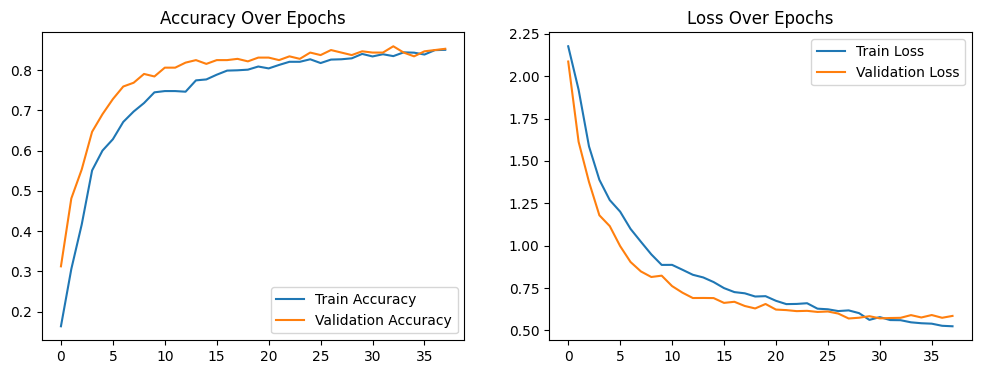

In [11]:
# TRAIN THE MODEL
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=80,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()


Test Accuracy: 0.7975
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

Classification Report:
                        precision    recall  f1-score   support

           Bridge-Pose       0.81      0.78      0.79        49
            Child-Pose       0.74      0.89      0.81        47
            Cobra-Pose       0.91      0.84      0.87        37
     Downward-Dog-Pose       0.77      0.71      0.74        42
           Pigeon-Pose       0.85      0.74      0.79        39
Standing-Mountain-Pose       0.73      0.67      0.70        36
             Tree-Pose       0.73      0.79      0.76        58
         Triangle-Pose       0.90      0.83      0.86        52
          Warrior-Pose       0.80      0.90      0.85        40

              accuracy                           0.80       400
             macro avg       0.80      0.79      0.80       400
          weighted avg       0.80      0.80      0.80       400



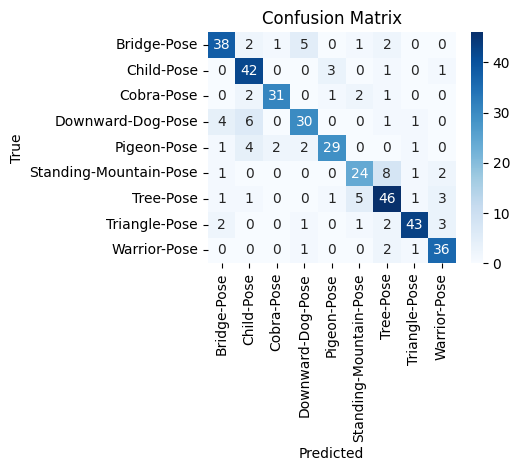

In [12]:
# EVALUATE THE MODEL
# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")

# Classification report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

# Confusion matrix
plt.figure(figsize=(4, 3))
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [13]:
def calculate_angle(a, b, c):
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    return angle if angle <= 180 else 360 - angle

In [14]:
def analyze_pose(image_path, model, label_encoder):
    """Analyze a new yoga pose and provide corrections"""
    # Extract keypoints
    keypoints = extract_keypoints(image_path)
    if not keypoints:
        return None, "No pose detected in the image"

    # Reshape for model prediction
    input_data = np.array(keypoints).reshape(1, -1, 1)

    # Predict pose
    prediction = model.predict(input_data)
    predicted_class = np.argmax(prediction)
    pose_name = label_encoder.inverse_transform([predicted_class])[0]
    confidence = np.max(prediction)

    # Calculate important angles
    angles = {}
    try:
        # Get all joint coordinates
        joints = {}
        for i in range(0, len(keypoints), 2):
            joint_idx = i // 2
            joints[f"joint_{joint_idx}"] = [keypoints[i], keypoints[i+1]]

        # Calculate common angles
        # Left arm (shoulder-elbow-wrist)
        angles['left_arm'] = calculate_angle(
            joints['joint_11'], joints['joint_13'], joints['joint_15'])

        # Right arm (shoulder-elbow-wrist)
        angles['right_arm'] = calculate_angle(
            joints['joint_12'], joints['joint_14'], joints['joint_16'])

        # Left leg (hip-knee-ankle)
        angles['left_leg'] = calculate_angle(
            joints['joint_23'], joints['joint_25'], joints['joint_27'])

        # Right leg (hip-knee-ankle)
        angles['right_leg'] = calculate_angle(
            joints['joint_24'], joints['joint_26'], joints['joint_28'])

        # Back angle (shoulder-hip-knee)
        angles['back'] = calculate_angle(
            joints['joint_11'], joints['joint_23'], joints['joint_25'])

        # Hip openness (left hip-right hip-knee)
        angles['hip_openness'] = calculate_angle(
            joints['joint_23'], joints['joint_24'], joints['joint_26'])

    except Exception as e:
        print(f"Angle calculation error: {str(e)}")

    # Generate pose-specific feedback
    feedback = []

    if pose_name == "Warrior-Pose":
        if angles.get('left_arm', 0) < 160:
            feedback.append("Straighten your left arm more (aim for 160°)")
        if angles.get('right_arm', 0) < 160:
            feedback.append("Straighten your right arm more (aim for 160°)")
        if angles.get('front_knee', 170) > 100:
            feedback.append("Bend your front knee deeper (aim for 90°)")

    elif pose_name == "Bridge-Pose":
        if angles.get('back', 180) < 150:  # Back arch angle
            feedback.append("Lift your hips higher (aim for 150° back arch)")
        elif angles.get('back', 0) > 170:
            feedback.append("Reduce over-arching - engage core muscles")

        if angles.get('left_leg', 0) < 90 or angles.get('right_leg', 0) < 90:  # Knee angles
            feedback.append("Keep knees aligned over ankles (90° bend)")

        if angles.get('hip_openness', 0) > 30:  # Hip width
            feedback.append("Bring knees closer together (hip-width apart)")

        if angles.get('left_arm', 180) < 170:  # Arm position
            feedback.append("Press shoulders firmly into the mat")

    elif pose_name == "Child-Pose":
        if angles.get('hip_openness', 0) > 60:
            feedback.append("Sink your hips back toward your heels more")
        if angles.get('back', 0) < 170:
            feedback.append("Relax your torso completely onto thighs")

    elif pose_name == "Cobra-Pose":
        if angles.get('back', 0) < 150:
            feedback.append("Lift your chest higher (aim for 150° back arch)")
        if angles.get('left_arm', 0) < 160:
            feedback.append("Straighten your arms more")
        if angles.get('hip_openness', 0) < 170:
            feedback.append("Keep your legs closer together")

    elif pose_name == "Pigeon-Pose":
        if angles.get('front_knee', 180) < 90:
            feedback.append("Bring your front foot closer to your body")
        if angles.get('back', 0) < 170:
            feedback.append("Square your hips forward")
        if angles.get('left_arm', 0) < 160:
            feedback.append("Extend your arms forward more")

    elif pose_name == "Downward-Dog":
        if angles.get('left_arm', 0) < 160:
            feedback.append("Straighten your arms completely (push chest back)")
        if angles.get('left_leg', 0) < 150:
            feedback.append("Straighten your legs more (lift hips higher)")
        if angles.get('back', 0) < 150:
            feedback.append("Lengthen your spine (avoid rounding back)")

    elif pose_name == "Standing-Mountain":
        if angles.get('left_arm', 0) < 170:
            feedback.append("Keep arms straight by your sides")
        if angles.get('left_leg', 0) < 170:
            feedback.append("Engage your thigh muscles to straighten legs")
        if angles.get('hip_openness', 0) < 170:
            feedback.append("Bring feet closer together (hip-width apart)")

    elif pose_name == "Tree-Pose":
        if angles.get('standing_leg', 0) < 170:
            feedback.append("Straighten your standing leg more")
        if angles.get('hip_openness', 0) > 45:
            feedback.append("Bring your foot higher on inner thigh")
        if angles.get('left_arm', 0) < 160:
            feedback.append("Bring palms together at chest or overhead")

    elif pose_name == "Triangle-Pose":
        if angles.get('front_knee', 180) < 170:
            feedback.append("Straighten your front leg completely")
        if angles.get('torso_angle', 0) < 80:
            feedback.append("Lean sideways more (aim for 90° from legs)")
        if angles.get('left_arm', 0) < 160:
            feedback.append("Extend both arms in one straight line")

    # Default feedback if no specific corrections
    if not feedback:
        feedback.append("Your pose looks good! Maintain this alignment.")

    return pose_name, confidence, angles, feedback

Saving pigeon pose.png to pigeon pose.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step

Pose Analysis Results:
- Predicted Pose: Pigeon-Pose (Confidence: 72.86%)
- Key Angles:
  Left Arm: 77.8°
  Right Arm: 73.3°
  Left Leg: 67.7°
  Right Leg: 4.9°
  Back: 111.6°
  Hip Openness: 158.8°
- Feedback:
  → Square your hips forward
  → Extend your arms forward more


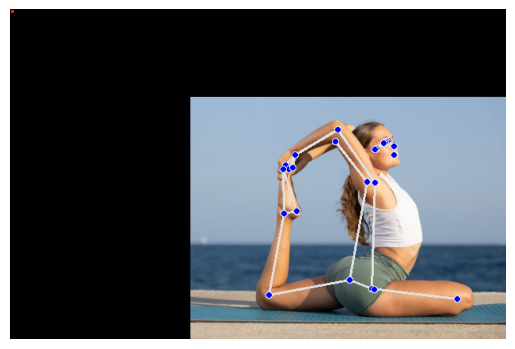

In [15]:
# TEST ON NEW IMAGE
# Upload a test image
from google.colab import files
uploaded = files.upload()
test_image_path = next(iter(uploaded))

# Analyze the pose
pose_name, confidence, angles, feedback = analyze_pose(test_image_path, model, label_encoder)

print("\nPose Analysis Results:")
print(f"- Predicted Pose: {pose_name} (Confidence: {confidence:.2%})")
print("- Key Angles:")
for joint, angle in angles.items():
    print(f"  {joint.replace('_', ' ').title()}: {angle:.1f}°")
print("- Feedback:")
for item in feedback:
    print(f"  → {item}")

# Display the image with keypoints
image = cv2.imread(test_image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
results = pose.process(image_rgb)
if results.pose_landmarks:
    mp_drawing.draw_landmarks(
        image_rgb,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS
    )
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

Saving bad pigeon pose.png to bad pigeon pose.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Pose Analysis Results:
- Predicted Pose: Pigeon-Pose (Confidence: 99.79%)
- Key Angles:
  Left Arm: 178.4°
  Right Arm: 178.5°
  Left Leg: 153.3°
  Right Leg: 51.6°
  Back: 107.6°
  Hip Openness: 142.6°
- Feedback:
  → Square your hips forward


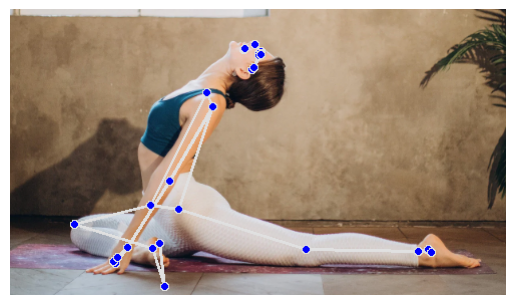

In [18]:
# TEST ON NEW IMAGE
# Upload a test image
from google.colab import files
uploaded = files.upload()
test_image_path = next(iter(uploaded))

# Analyze the pose
pose_name, confidence, angles, feedback = analyze_pose(test_image_path, model, label_encoder)

print("\nPose Analysis Results:")
print(f"- Predicted Pose: {pose_name} (Confidence: {confidence:.2%})")
print("- Key Angles:")
for joint, angle in angles.items():
    print(f"  {joint.replace('_', ' ').title()}: {angle:.1f}°")
print("- Feedback:")
for item in feedback:
    print(f"  → {item}")

# Display the image with keypoints
image = cv2.imread(test_image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
results = pose.process(image_rgb)
if results.pose_landmarks:
    mp_drawing.draw_landmarks(
        image_rgb,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS
    )
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

Saving Child tree pose.png to Child tree pose.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

Pose Analysis Results:
- Predicted Pose: Tree-Pose (Confidence: 93.70%)
- Key Angles:
  Left Arm: 51.0°
  Right Arm: 36.8°
  Left Leg: 44.4°
  Right Leg: 166.3°
  Back: 109.5°
  Hip Openness: 97.1°
- Feedback:
  → Straighten your standing leg more
  → Bring your foot higher on inner thigh
  → Bring palms together at chest or overhead


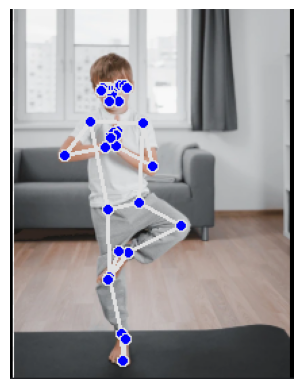

In [19]:
# TEST ON NEW IMAGE
# Upload a test image
from google.colab import files
uploaded = files.upload()
test_image_path = next(iter(uploaded))

# Analyze the pose
pose_name, confidence, angles, feedback = analyze_pose(test_image_path, model, label_encoder)

print("\nPose Analysis Results:")
print(f"- Predicted Pose: {pose_name} (Confidence: {confidence:.2%})")
print("- Key Angles:")
for joint, angle in angles.items():
    print(f"  {joint.replace('_', ' ').title()}: {angle:.1f}°")
print("- Feedback:")
for item in feedback:
    print(f"  → {item}")

# Display the image with keypoints
image = cv2.imread(test_image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
results = pose.process(image_rgb)
if results.pose_landmarks:
    mp_drawing.draw_landmarks(
        image_rgb,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS
    )
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

Saving bad child tree pose.png to bad child tree pose.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

Pose Analysis Results:
- Predicted Pose: Tree-Pose (Confidence: 56.93%)
- Key Angles:
  Left Arm: 179.3°
  Right Arm: 178.8°
  Left Leg: 155.3°
  Right Leg: 175.9°
  Back: 169.5°
  Hip Openness: 81.9°
- Feedback:
  → Straighten your standing leg more
  → Bring your foot higher on inner thigh


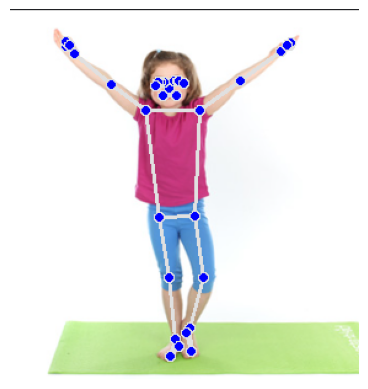

In [20]:
# TEST ON NEW IMAGE
# Upload a test image
from google.colab import files
uploaded = files.upload()
test_image_path = next(iter(uploaded))

# Analyze the pose
pose_name, confidence, angles, feedback = analyze_pose(test_image_path, model, label_encoder)

print("\nPose Analysis Results:")
print(f"- Predicted Pose: {pose_name} (Confidence: {confidence:.2%})")
print("- Key Angles:")
for joint, angle in angles.items():
    print(f"  {joint.replace('_', ' ').title()}: {angle:.1f}°")
print("- Feedback:")
for item in feedback:
    print(f"  → {item}")

# Display the image with keypoints
image = cv2.imread(test_image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
results = pose.process(image_rgb)
if results.pose_landmarks:
    mp_drawing.draw_landmarks(
        image_rgb,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS
    )
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

Saving bridge pose.jpeg to bridge pose.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step

Pose Analysis Results:
- Predicted Pose: Bridge-Pose (Confidence: 53.22%)
- Key Angles:
  Left Arm: 152.1°
  Right Arm: 155.1°
  Left Leg: 110.6°
  Right Leg: 106.2°
  Back: 126.3°
  Hip Openness: 72.8°
- Feedback:
  → Lift your hips higher (aim for 150° back arch)
  → Bring knees closer together (hip-width apart)
  → Press shoulders firmly into the mat


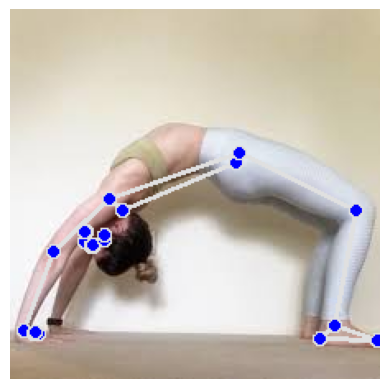

In [21]:
# TEST ON NEW IMAGE
# Upload a test image
from google.colab import files
uploaded = files.upload()
test_image_path = next(iter(uploaded))

# Analyze the pose
pose_name, confidence, angles, feedback = analyze_pose(test_image_path, model, label_encoder)

print("\nPose Analysis Results:")
print(f"- Predicted Pose: {pose_name} (Confidence: {confidence:.2%})")
print("- Key Angles:")
for joint, angle in angles.items():
    print(f"  {joint.replace('_', ' ').title()}: {angle:.1f}°")
print("- Feedback:")
for item in feedback:
    print(f"  → {item}")

# Display the image with keypoints
image = cv2.imread(test_image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
results = pose.process(image_rgb)
if results.pose_landmarks:
    mp_drawing.draw_landmarks(
        image_rgb,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS
    )
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

Saving bad warrior pose.webp to bad warrior pose.webp
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Pose Analysis Results:
- Predicted Pose: Warrior-Pose (Confidence: 88.99%)
- Key Angles:
  Left Arm: 177.1°
  Right Arm: 173.0°
  Left Leg: 110.6°
  Right Leg: 173.2°
  Back: 114.1°
  Hip Openness: 114.8°
- Feedback:
  → Bend your front knee deeper (aim for 90°)


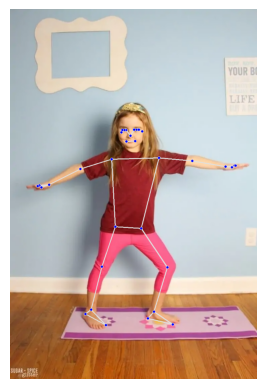

In [23]:
# TEST ON NEW IMAGE
# Upload a test image
from google.colab import files
uploaded = files.upload()
test_image_path = next(iter(uploaded))

# Analyze the pose
pose_name, confidence, angles, feedback = analyze_pose(test_image_path, model, label_encoder)

print("\nPose Analysis Results:")
print(f"- Predicted Pose: {pose_name} (Confidence: {confidence:.2%})")
print("- Key Angles:")
for joint, angle in angles.items():
    print(f"  {joint.replace('_', ' ').title()}: {angle:.1f}°")
print("- Feedback:")
for item in feedback:
    print(f"  → {item}")

# Display the image with keypoints
image = cv2.imread(test_image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
results = pose.process(image_rgb)
if results.pose_landmarks:
    mp_drawing.draw_landmarks(
        image_rgb,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS
    )
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

Saving warrior pose.webp to warrior pose.webp
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Pose Analysis Results:
- Predicted Pose: Warrior-Pose (Confidence: 95.54%)
- Key Angles:
  Left Arm: 178.1°
  Right Arm: 163.5°
  Left Leg: 140.2°
  Right Leg: 176.0°
  Back: 131.7°
  Hip Openness: 113.6°
- Feedback:
  → Bend your front knee deeper (aim for 90°)


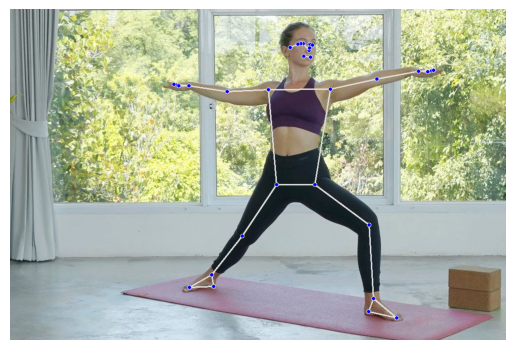

In [24]:
# TEST ON NEW IMAGE
# Upload a test image
from google.colab import files
uploaded = files.upload()
test_image_path = next(iter(uploaded))

# Analyze the pose
pose_name, confidence, angles, feedback = analyze_pose(test_image_path, model, label_encoder)

print("\nPose Analysis Results:")
print(f"- Predicted Pose: {pose_name} (Confidence: {confidence:.2%})")
print("- Key Angles:")
for joint, angle in angles.items():
    print(f"  {joint.replace('_', ' ').title()}: {angle:.1f}°")
print("- Feedback:")
for item in feedback:
    print(f"  → {item}")

# Display the image with keypoints
image = cv2.imread(test_image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
results = pose.process(image_rgb)
if results.pose_landmarks:
    mp_drawing.draw_landmarks(
        image_rgb,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS
    )
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

Saving mountain pose.jpeg to mountain pose.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

Pose Analysis Results:
- Predicted Pose: Standing-Mountain-Pose (Confidence: 96.08%)
- Key Angles:
  Left Arm: 178.4°
  Right Arm: 177.2°
  Left Leg: 178.7°
  Right Leg: 177.9°
  Back: 177.0°
  Hip Openness: 92.4°
- Feedback:
  → Your pose looks good! Maintain this alignment.


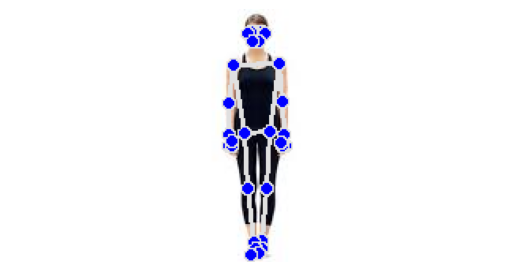

In [25]:
# TEST ON NEW IMAGE
# Upload a test image
from google.colab import files
uploaded = files.upload()
test_image_path = next(iter(uploaded))

# Analyze the pose
pose_name, confidence, angles, feedback = analyze_pose(test_image_path, model, label_encoder)

print("\nPose Analysis Results:")
print(f"- Predicted Pose: {pose_name} (Confidence: {confidence:.2%})")
print("- Key Angles:")
for joint, angle in angles.items():
    print(f"  {joint.replace('_', ' ').title()}: {angle:.1f}°")
print("- Feedback:")
for item in feedback:
    print(f"  → {item}")

# Display the image with keypoints
image = cv2.imread(test_image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
results = pose.process(image_rgb)
if results.pose_landmarks:
    mp_drawing.draw_landmarks(
        image_rgb,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS
    )
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

Saving dog pose kiddo.jpeg to dog pose kiddo.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

Pose Analysis Results:
- Predicted Pose: Downward-Dog-Pose (Confidence: 97.28%)
- Key Angles:
  Left Arm: 163.1°
  Right Arm: 166.3°
  Left Leg: 155.7°
  Right Leg: 169.8°
  Back: 57.1°
  Hip Openness: 138.7°
- Feedback:
  → Your pose looks good! Maintain this alignment.


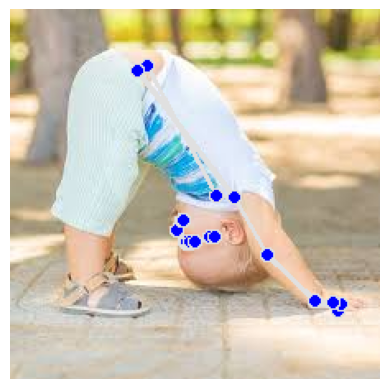

In [28]:
# TEST ON NEW IMAGE
# Upload a test image
from google.colab import files
uploaded = files.upload()
test_image_path = next(iter(uploaded))

# Analyze the pose
pose_name, confidence, angles, feedback = analyze_pose(test_image_path, model, label_encoder)

print("\nPose Analysis Results:")
print(f"- Predicted Pose: {pose_name} (Confidence: {confidence:.2%})")
print("- Key Angles:")
for joint, angle in angles.items():
    print(f"  {joint.replace('_', ' ').title()}: {angle:.1f}°")
print("- Feedback:")
for item in feedback:
    print(f"  → {item}")

# Display the image with keypoints
image = cv2.imread(test_image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
results = pose.process(image_rgb)
if results.pose_landmarks:
    mp_drawing.draw_landmarks(
        image_rgb,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS
    )
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

Saving dog pose.jpeg to dog pose.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

Pose Analysis Results:
- Predicted Pose: Downward-Dog-Pose (Confidence: 99.44%)
- Key Angles:
  Left Arm: 175.9°
  Right Arm: 173.0°
  Left Leg: 178.6°
  Right Leg: 178.8°
  Back: 55.0°
  Hip Openness: 95.2°
- Feedback:
  → Your pose looks good! Maintain this alignment.


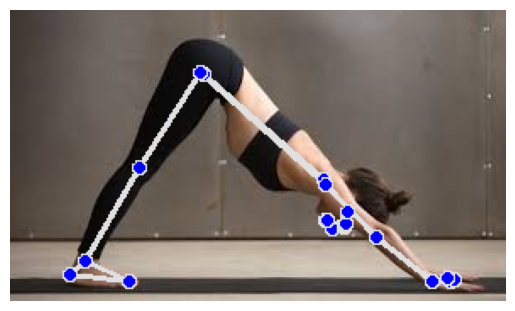

In [30]:
# TEST ON NEW IMAGE
# Upload a test image
from google.colab import files
uploaded = files.upload()
test_image_path = next(iter(uploaded))

# Analyze the pose
pose_name, confidence, angles, feedback = analyze_pose(test_image_path, model, label_encoder)

print("\nPose Analysis Results:")
print(f"- Predicted Pose: {pose_name} (Confidence: {confidence:.2%})")
print("- Key Angles:")
for joint, angle in angles.items():
    print(f"  {joint.replace('_', ' ').title()}: {angle:.1f}°")
print("- Feedback:")
for item in feedback:
    print(f"  → {item}")

# Display the image with keypoints
image = cv2.imread(test_image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
results = pose.process(image_rgb)
if results.pose_landmarks:
    mp_drawing.draw_landmarks(
        image_rgb,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS
    )
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

Saving cobra pose.jpeg to cobra pose.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

Pose Analysis Results:
- Predicted Pose: Cobra-Pose (Confidence: 99.73%)
- Key Angles:
  Left Arm: 168.6°
  Right Arm: 176.6°
  Left Leg: 163.6°
  Right Leg: 160.3°
  Back: 127.9°
  Hip Openness: 88.1°
- Feedback:
  → Lift your chest higher (aim for 150° back arch)
  → Keep your legs closer together


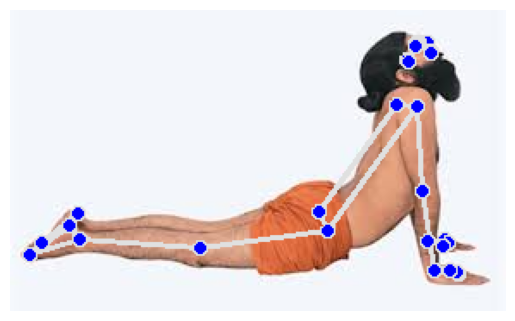

In [31]:
# TEST ON NEW IMAGE
# Upload a test image
from google.colab import files
uploaded = files.upload()
test_image_path = next(iter(uploaded))

# Analyze the pose
pose_name, confidence, angles, feedback = analyze_pose(test_image_path, model, label_encoder)

print("\nPose Analysis Results:")
print(f"- Predicted Pose: {pose_name} (Confidence: {confidence:.2%})")
print("- Key Angles:")
for joint, angle in angles.items():
    print(f"  {joint.replace('_', ' ').title()}: {angle:.1f}°")
print("- Feedback:")
for item in feedback:
    print(f"  → {item}")

# Display the image with keypoints
image = cv2.imread(test_image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
results = pose.process(image_rgb)
if results.pose_landmarks:
    mp_drawing.draw_landmarks(
        image_rgb,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS
    )
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

Saving wrong cobra pose.png to wrong cobra pose.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

Pose Analysis Results:
- Predicted Pose: Cobra-Pose (Confidence: 93.12%)
- Key Angles:
  Left Arm: 164.8°
  Right Arm: 158.8°
  Left Leg: 166.7°
  Right Leg: 169.9°
  Back: 137.2°
  Hip Openness: 100.8°
- Feedback:
  → Lift your chest higher (aim for 150° back arch)
  → Keep your legs closer together


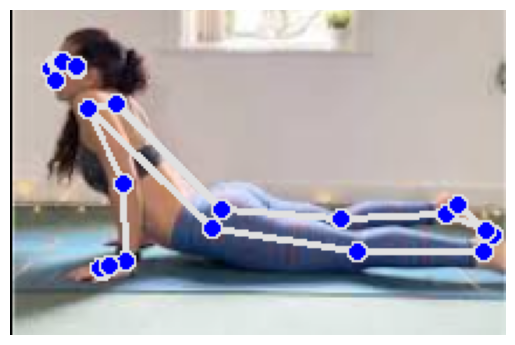

In [32]:
# TEST ON NEW IMAGE
# Upload a test image
from google.colab import files
uploaded = files.upload()
test_image_path = next(iter(uploaded))

# Analyze the pose
pose_name, confidence, angles, feedback = analyze_pose(test_image_path, model, label_encoder)

print("\nPose Analysis Results:")
print(f"- Predicted Pose: {pose_name} (Confidence: {confidence:.2%})")
print("- Key Angles:")
for joint, angle in angles.items():
    print(f"  {joint.replace('_', ' ').title()}: {angle:.1f}°")
print("- Feedback:")
for item in feedback:
    print(f"  → {item}")

# Display the image with keypoints
image = cv2.imread(test_image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
results = pose.process(image_rgb)
if results.pose_landmarks:
    mp_drawing.draw_landmarks(
        image_rgb,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS
    )
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

Saving cobra pose by kiddo.jpeg to cobra pose by kiddo.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

Pose Analysis Results:
- Predicted Pose: Cobra-Pose (Confidence: 98.96%)
- Key Angles:
  Left Arm: 172.6°
  Right Arm: 174.4°
  Left Leg: 170.6°
  Right Leg: 178.6°
  Back: 145.1°
  Hip Openness: 89.8°
- Feedback:
  → Lift your chest higher (aim for 150° back arch)
  → Keep your legs closer together


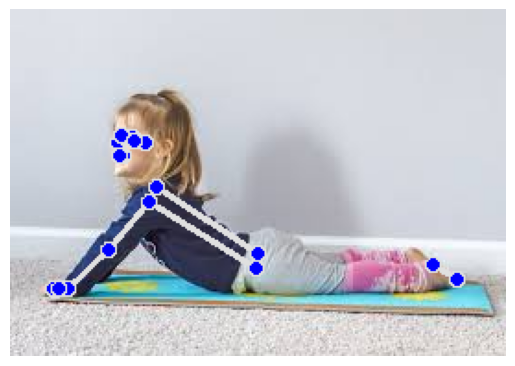

In [33]:
# TEST ON NEW IMAGE
# Upload a test image
from google.colab import files
uploaded = files.upload()
test_image_path = next(iter(uploaded))

# Analyze the pose
pose_name, confidence, angles, feedback = analyze_pose(test_image_path, model, label_encoder)

print("\nPose Analysis Results:")
print(f"- Predicted Pose: {pose_name} (Confidence: {confidence:.2%})")
print("- Key Angles:")
for joint, angle in angles.items():
    print(f"  {joint.replace('_', ' ').title()}: {angle:.1f}°")
print("- Feedback:")
for item in feedback:
    print(f"  → {item}")

# Display the image with keypoints
image = cv2.imread(test_image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
results = pose.process(image_rgb)
if results.pose_landmarks:
    mp_drawing.draw_landmarks(
        image_rgb,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS
    )
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

Saving cobra pose by another kiddo.jpeg to cobra pose by another kiddo (1).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

Pose Analysis Results:
- Predicted Pose: Cobra-Pose (Confidence: 96.97%)
- Key Angles:
  Left Arm: 177.1°
  Right Arm: 171.9°
  Left Leg: 178.9°
  Right Leg: 173.0°
  Back: 120.2°
  Hip Openness: 90.2°
- Feedback:
  → Lift your chest higher (aim for 150° back arch)
  → Keep your legs closer together


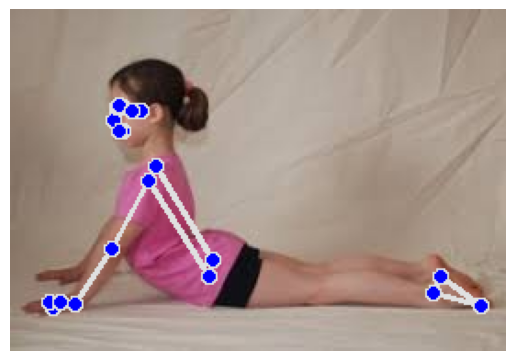

In [16]:
# TEST ON NEW IMAGE
# Upload a test image
from google.colab import files
uploaded = files.upload()
test_image_path = next(iter(uploaded))

# Analyze the pose
pose_name, confidence, angles, feedback = analyze_pose(test_image_path, model, label_encoder)

print("\nPose Analysis Results:")
print(f"- Predicted Pose: {pose_name} (Confidence: {confidence:.2%})")
print("- Key Angles:")
for joint, angle in angles.items():
    print(f"  {joint.replace('_', ' ').title()}: {angle:.1f}°")
print("- Feedback:")
for item in feedback:
    print(f"  → {item}")

# Display the image with keypoints
image = cv2.imread(test_image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
results = pose.process(image_rgb)
if results.pose_landmarks:
    mp_drawing.draw_landmarks(
        image_rgb,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS
    )
plt.imshow(image_rgb)
plt.axis('off')
plt.show()